In [1]:
from jax import config
#config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)

import jax 
from jax import jit,vmap
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from typing import Callable
from jax import value_and_grad
from pathlib import Path

In [2]:
import sheap
from sheap.spectra_readers import parallel_reader 
from sheap.MainSheap import Sheapectral 
from sheap.RegionHandler.RegionBuilder import RegionBuilder
from sheap.RegionFitting.RegionFitting import RegionFitting
from sheap.Plotting.SheapPlot import SheapPlot
from sheap.Posterior.ParameterEstimation import ParameterEstimation
from sheap.tools.paths_func import cross_pandas_spectra
from sheap.HostSubtraction import HostSubtraction
from sheap.FunctionsMinimize.utils import combine_auto

In [3]:
from errors import batch_error_covariance_in_chunks

In [3]:
%load_ext autoreload
%autoreload 2

### A

In [5]:
spectrum_dic = Path(sheap.__file__).resolve().parent / "SuportData" / "Spectrum"
files = glob.glob(f"{spectrum_dic}/*")


In [6]:
coords,spectra,_ = parallel_reader(files) 
z = [0.161769,0.184366]

In [7]:
sheapspectral = Sheapectral(spectra,z=z,coords=coords)

extinction correction will be do it, change 'extinction_correction' to done if you want to avoid this step


redshift correction will be do it, change 'redshift_correction' to done if you want to avoid this step


In [8]:
sheapspectral.build_region(6000,8000,n_broad=1)

added OP template


In [9]:
sheapspectral.fit_region(num_steps_list=[1000,1000])

Fitting 2 spectra
STEP1
learning_rate: 0.1 num_steps: 1000 non_optimize_in_axis: 3
STEP2
learning_rate: 0.01 num_steps: 1000 non_optimize_in_axis: 4
running uncertainty


Array([[ 3.50000000e+00,  2.26146410e+01,  2.41443661e-17,
         1.58851916e-17,  7.05958333e+03,  4.71339142e+00,
         3.95313804e-17,  7.06808572e+03,  3.34890064e+01,
         1.67514399e-17,  7.27639732e+03,  1.45223748e+00,
         4.36574737e-18,  7.28951250e+03,  2.48724655e+01,
         0.00000000e+00,  7.81680938e+03,  4.39201176e+00,
         1.38834346e-17,  7.86740930e+03,  3.71587955e+01,
         2.56191489e-17,  6.07983475e+03,  9.51114246e+00,
         0.00000000e+00,  7.00480449e+03,  3.03320586e+01,
         1.30105960e-18,  7.25037764e+03,  2.92831722e+01,
         1.06914345e-17,  7.74715300e+03,  3.06471480e+01,
         4.90978833e-16,  6.56294500e+03,  4.37824223e+00,
         2.22287092e-15,  6.56512136e+03,  2.82012932e+01,
         2.79944069e-17,  6.30702540e+03,  4.20311041e+00,
         0.00000000e+00,  6.36757048e+03,  4.24547038e+00,
         7.81890080e-17,  6.71790633e+03,  4.48072646e+00,
         5.67723913e-17,  6.73458355e+03,  4.49031310e+0

In [16]:
model = combine_auto(sheapspectral.profile_functions)

In [38]:
def residuals(func: Callable, params: jnp.ndarray, xs: jnp.ndarray, y: jnp.ndarray, y_uncertainties: jnp.ndarray) -> jnp.ndarray:
    predictions = func(xs, params)
    return jnp.abs(y - predictions) / y_uncertainties

In [86]:
from sheap.RegionFitting.uncertainty_functions import error_covariance_matrix_single

def error_for_loop(model,params,spectra):
    x,y,error = jnp.moveaxis(spectra,0,1)
    list = jnp.zeros_like(params)
    for n,(params_i,x_i,y_i,error_i) in enumerate(zip(params,x,y,error)):
        sigma = error_covariance_matrix_single(model,params_i,x_i,y_i,error_i,free_params=1)
        list = list.at[n].set(sigma)
        #list[n] = sigma
        #list.append(sigma)
    return list

In [88]:
errors_sigmas

Array([[4.67317353e-02, 3.16295309e-01, 7.33221515e-19, 7.42929050e-17,
        2.49651859e+01, 2.79014634e+01, 3.61485394e-17, 3.84842449e+01,
        3.83916439e+01, 1.35691805e-16, 1.30097978e+01, 1.34274520e+01,
        4.67169666e-16, 1.67459202e+03, 7.58301888e+02, 6.40060020e-17,
        1.11729351e+04, 1.11729351e+04, 2.33513412e-17, 8.62165810e+01,
        9.49466716e+01, 4.88346690e-17, 2.08067118e+01, 2.07628209e+01,
        4.30799643e-17, 1.11729351e+04, 1.11729351e+04, 3.54567442e-16,
        9.30320653e+03, 3.24440448e+03, 2.65864920e-17, 9.78414475e+01,
        1.11453217e+02, 6.39847217e-16, 1.26671713e+01, 8.23728015e+00,
        1.70939243e-16, 1.03961362e+00, 9.91132769e-01, 7.33822249e-17,
        1.31152824e+01, 1.34975189e+01, 6.28080487e-17, 1.11729351e+04,
        1.11729351e+04, 7.67684461e-17, 5.59476390e+00, 6.14507630e+00,
        8.12563959e-17, 7.17422418e+00, 7.82223343e+00, 6.74460632e-17,
        1.30818465e+02, 1.51687535e+02, 3.94532276e-16, 1.018116

In [87]:
errors_sigmas = error_for_loop(model,sheapspectral.params,sheapspectral.spectra)

In [81]:
errors_sigmas

[Array([4.67317353e-02, 3.16295309e-01, 7.33221515e-19, 7.42929050e-17,
        2.49651859e+01, 2.79014634e+01, 3.61485394e-17, 3.84842449e+01,
        3.83916439e+01, 1.35691805e-16, 1.30097978e+01, 1.34274520e+01,
        4.67169666e-16, 1.67459202e+03, 7.58301888e+02, 6.40060020e-17,
        1.11729351e+04, 1.11729351e+04, 2.33513412e-17, 8.62165810e+01,
        9.49466716e+01, 4.88346690e-17, 2.08067118e+01, 2.07628209e+01,
        4.30799643e-17, 1.11729351e+04, 1.11729351e+04, 3.54567442e-16,
        9.30320653e+03, 3.24440448e+03, 2.65864920e-17, 9.78414475e+01,
        1.11453217e+02, 6.39847217e-16, 1.26671713e+01, 8.23728015e+00,
        1.70939243e-16, 1.03961362e+00, 9.91132769e-01, 7.33822249e-17,
        1.31152824e+01, 1.34975189e+01, 6.28080487e-17, 1.11729351e+04,
        1.11729351e+04, 7.67684461e-17, 5.59476390e+00, 6.14507630e+00,
        8.12563959e-17, 7.17422418e+00, 7.82223343e+00, 6.74460632e-17,
        1.30818465e+02, 1.51687535e+02, 3.94532276e-16, 1.018116

In [ ]:
yerr_i =sheapspectral.mask[0],1e31,yerr_i

In [68]:
params_i = sheapspectral.params[0]
xs_i,y_i,yerr_i = sheapspectral.spectra[0]

In [69]:
residual =  residuals(model, params_i, xs_i, y_i, yerr_i)
#jnp.where(sheapspectral.mask[0],0.0001,residuals(model, params_i, xs_i, y_i, yerr_i))

In [73]:
residual

Array([10.85198367, 13.19400886, 12.86287292, ...,  0.04448004,
        0.38542526,  0.65378656], dtype=float64)

In [70]:
jac_fn = lambda p: residuals(model, p, xs_i, y_i, yerr_i)

In [71]:
jacobian = jax.jacobian(jac_fn)(params_i)
JTJ = jacobian.T @ jacobian
dof = residual.shape[0] - 0
s_sq = jnp.sum(residual ** 2) / dof
cov = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(params_i.shape[0])) * s_sq
errors = jnp.sqrt(jnp.diag(cov))

In [72]:
errors

Array([4.67266444e-02, 3.16260853e-01, 7.33141639e-19, 7.42848116e-17,
       2.49624662e+01, 2.78984239e+01, 3.61446014e-17, 3.84800525e+01,
       3.83874616e+01, 1.35677023e-16, 1.30083805e+01, 1.34259892e+01,
       4.67118774e-16, 1.67440960e+03, 7.58219280e+02, 6.39990292e-17,
       1.11717179e+04, 1.11717179e+04, 2.33487973e-17, 8.62071887e+01,
       9.49363282e+01, 4.88293491e-17, 2.08044452e+01, 2.07605590e+01,
       4.30752712e-17, 1.11717179e+04, 1.11717179e+04, 3.54528816e-16,
       9.30219306e+03, 3.24405104e+03, 2.65835957e-17, 9.78307889e+01,
       1.11441076e+02, 6.39777513e-16, 1.26657913e+01, 8.23638279e+00,
       1.70920621e-16, 1.03950036e+00, 9.91024797e-01, 7.33742307e-17,
       1.31138536e+01, 1.34960485e+01, 6.28012065e-17, 1.11717179e+04,
       1.11717179e+04, 7.67600831e-17, 5.59415442e+00, 6.14440686e+00,
       8.12475439e-17, 7.17344263e+00, 7.82138129e+00, 6.74387157e-17,
       1.30804214e+02, 1.51671011e+02, 3.94489296e-16, 1.01800556e+01,
      

In [48]:
jacobian.shape

(4590, 62)

In [ ]:



jac_fn = lambda p: residuals(func, p, xs_i, y_i, yerr_i)
jacobian = jax.jacobian(jac_fn)(params_i)
JTJ = jacobian.T @ jacobian
dof = residual.shape[0] - free_params
s_sq = jnp.sum(residual ** 2) / dof
cov = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(params_i.shape[0])) * s_sq

### B

In [4]:
sheapclass = Sheapectral.from_pickle("model_mode.pkl")

In [18]:
#sheapclass.complex_region_class

In [6]:
sheapclass.build_region(6000,8000,n_broad=1)

added OP template


In [7]:
sheapclass.fit_region(num_steps_list=[100,100])

Fitting 225 spectra
STEP1
learning_rate: 0.1 num_steps: 100 non_optimize_in_axis: 3
STEP2
learning_rate: 0.01 num_steps: 100 non_optimize_in_axis: 4
running uncertainty


In [120]:
parameterestimation = ParameterEstimation(sheapclass)

In [121]:
dd=parameterestimation.compute_Luminosity_w()

In [115]:
parameterestimation.compute_params_wu()

In [122]:
parameterestimation.compute_bolometric_luminosity()

{'1350.0': {'value': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [104]:
l.value.shape

(225,)

In [ ]:
#grad_f = grad(lambda p: jnp.sum(profile_func(jnp.array([w]), p), axis=-1))(params)  # shape (225, n_params)

In [96]:
L_w

{'1350.0': {'value': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,)),
  'error': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,))},
 '1450.0': {'value': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,)),
  'error': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,))},
 '3000.0': {'value': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,)),
  'error': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,))},
 '5100.0': {'value': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,)),
  'error': array([0., 0., 0., ..., 0., 0., 0.], shape=(50625,))},
 '6200.0': {'value': array([7.88070557e+43, 1.10459947e+44, 4.41577831e+43, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(50625,)),
  'error': array([3.30329344e+42, 8.20726396e+42, 4.83986628e+42, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(50625,))}}

In [ ]:
grad_f(uncertainty_params)

(2, 225)

In [60]:
profile_func(jnp.array([w]),params).shape

(225,)

In [52]:
profile_func(jnp.array([1350.]),params.T)

Array([1.60304069e-15, 2.06213077e-15, 1.06780194e-15, 8.75085390e-16,
       6.07958351e-16, 3.42989951e-16, 6.92057333e-16, 3.27285676e-16,
       3.06624389e-16, 3.68021991e-16, 2.32983512e-16, 3.47706992e-16,
       2.78568627e-16, 0.00000000e+00, 2.52266146e-16, 2.24696052e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20867681e-16,
       2.43147380e-16, 0.00000000e+00, 1.79973407e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.68350250e-16,
       1.72081260e-16, 1.97622215e-16, 1.49160872e-16, 0.00000000e+00,
       0.00000000e+00, 1.29337463e-16, 0.00000000e+00, 1.37196986e-16,
       0.00000000e+00, 0.00000000e+00, 1.69440473e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.35972864e-17,
       0.00000000e+00, 1.28348643e-16, 0.00000000e+00, 1.23028911e-16,
       0.00000000e+00, 1.17357979e-16, 1.59225283e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.24232051e-17,
      

In [40]:
def scalar_flux(params, w):
    return jnp.sum(profile_func(jnp.array([w]), params), axis=-1)  # shape (N_spectra,)

# Gradient of scalar flux per spectrum
def grad_flux(p, w):
    return grad(lambda p_: jnp.sum(profile_func(jnp.array([w]), p_), axis=-1))(p)  # shape (N_spectra, n_params)

# Evaluate flux and gradients
w = 5100.  # example
flux = profile_func(jnp.array([w]), params)  # shape (225, 2)
#flux_scalar = jnp.sum(flux, axis=-1)         # shape (225,)

#grad_f = grad(lambda p: jnp.sum(profile_func(jnp.array([w]), p), axis=-1))(params)  # shape (225, n_params)
#sigma_f = jnp.sqrt(jnp.sum((grad_f * uncertainty_params)**2, axis=-1))             # shape (225,)


In [41]:
flux

Array([-1.71936354e-01,  2.83469696e-15], dtype=float64)

In [159]:
profile_func(jnp.array([w]),params)

AttributeError: 'jaxlib.xla_extension.PjitFunction' object has no attribute 'n_params'

In [147]:
parameterestimation.dict_basic_params['broad']

{'L': {'value': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          8.54458708e+43, 2.43470865e+44, 1.32910436e+46],
         [0.00000000e+00, 4.65697624e+43, 0.00000000e+00, ...,
          2.17230362e+44, 3.78487312e+44, 2.84416870e+46],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 9.19440822e+46],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(225, 8)),
  'error': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.70669799e+44, 5.44414884e+44, 1.63758492e+44],
         [0.00000000e+00, 5.04757918e+44, 0.00000000e+00, ...,
          5.69124517e+44, 3.

In [141]:
parameterestimation.dict_flux

{'continuum': {'value': array([], shape=(225, 0), dtype=float64),
  'error': array([], shape=(225, 0), dtype=float64),
  'lines': array(['powerlaw'], dtype='<U8')},
 'broad': {'value': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.69627845e-16, 7.15648186e-16, 4.65182002e-14],
         [0.00000000e+00, 1.47241009e-16, 0.00000000e+00, ...,
          6.60441134e-16, 1.07201901e-15, 9.59349657e-14],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.18089583e-14],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(225, 8)),
  'error': array([[0.00000000e+00, 0.00000000e+00, 0.

In [118]:
parameterestimation.complex_region_class.to_dict().keys()

dict_keys(['complex_region', 'profile_functions', 'params', 'uncertainty_params', 'profile_params_index_list', 'params_dict', 'profile_names', 'kind_list'])

In [103]:
for i in  set([i.kind for i in parameterestimation.complex_region]):
    print(i)


continuum
broad
fe
narrow


In [97]:
parameterestimation.compute_flux_wu()

Magnitude
Error


In [91]:
parameterestimation.params_dict

{'logFWHM_feop_21_fe': 0,
 'shift_feop_21_fe': 1,
 'scale_feop_21_fe': 2,
 'amplitude_OIa_1_broad': 3,
 'center_OIa_1_broad': 4,
 'width_OIa_1_broad': 5,
 'amplitude_OIb_1_broad': 6,
 'center_OIb_1_broad': 7,
 'width_OIb_1_broad': 8,
 'amplitude_OIc_1_broad': 9,
 'center_OIc_1_broad': 10,
 'width_OIc_1_broad': 11,
 'amplitude_OId_1_broad': 12,
 'center_OId_1_broad': 13,
 'width_OId_1_broad': 14,
 'amplitude_OIa_1_narrow': 15,
 'center_OIa_1_narrow': 16,
 'width_OIa_1_narrow': 17,
 'amplitude_OIb_1_narrow': 18,
 'center_OIb_1_narrow': 19,
 'width_OIb_1_narrow': 20,
 'amplitude_SIIa_1_narrow': 21,
 'center_SIIa_1_narrow': 22,
 'width_SIIa_1_narrow': 23,
 'amplitude_SIIb_1_narrow': 24,
 'center_SIIb_1_narrow': 25,
 'width_SIIb_1_narrow': 26,
 'amplitude_OIIc_1_narrow': 27,
 'center_OIIc_1_narrow': 28,
 'width_OIIc_1_narrow': 29,
 'amplitude_NIIb_1_narrow': 30,
 'center_NIIb_1_narrow': 31,
 'width_NIIb_1_narrow': 32,
 'amplitude_NIIa_1_narrow': 33,
 'center_NIIa_1_narrow': 34,
 'width_NIIa

In [63]:
amplitudes = [line.amplitude for line in parameterestimation.broad_map.lines]

In [72]:
from sheap.SuportFunctions.functions import mapping_params

In [70]:
type(parameterestimation.broad_map.params_names)

numpy.ndarray

In [80]:
broad_map = parameterestimation.broad_map

In [ ]:
idx_amplitude = mapping_params(broad_map.params_names,"amplitude")



In [83]:
idx_amplitude

Array([ 0,  3,  6,  9, 12, 15, 18, 21], dtype=int64)

In [41]:
parameterestimation.RegionMap.complex_region

[SpectralLine(center=0, line_name='feop', kind='fe', component=21, amplitude=0, how='template', region='OP', profile='fitFeOP', which='OP'),
 SpectralLine(center=6046.44, line_name='OIa', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7002.23, line_name='OIb', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7254.448, line_name='OIc', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7774.17, line_name='OId', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=6300.304, line_name='OIa', kind='narrow', component=1, amplitude=1.0, how=None, region='narrow_basic', profile='gaussian', which=None),
 SpectralLine(center=6363.8, line_name='OIb', kind='narrow', component=1, amplitude=1.0, how=None, region='na

In [39]:
parameterestimation.complex_region_class.to_dict()['complex_region']

list

In [31]:
parameterestimation.RegionMap.complex_region

[{'center': 0,
  'line_name': 'feop',
  'kind': 'fe',
  'component': 21,
  'amplitude': 0,
  'how': 'template',
  'region': 'OP',
  'profile': 'fitFeOP',
  'which': 'OP'},
 {'center': 6046.44,
  'line_name': 'OIa',
  'kind': 'broad',
  'component': 1,
  'amplitude': 1.0,
  'how': None,
  'region': 'broad',
  'profile': 'gaussian',
  'which': None},
 {'center': 7002.23,
  'line_name': 'OIb',
  'kind': 'broad',
  'component': 1,
  'amplitude': 1.0,
  'how': None,
  'region': 'broad',
  'profile': 'gaussian',
  'which': None},
 {'center': 7254.448,
  'line_name': 'OIc',
  'kind': 'broad',
  'component': 1,
  'amplitude': 1.0,
  'how': None,
  'region': 'broad',
  'profile': 'gaussian',
  'which': None},
 {'center': 7774.17,
  'line_name': 'OId',
  'kind': 'broad',
  'component': 1,
  'amplitude': 1.0,
  'how': None,
  'region': 'broad',
  'profile': 'gaussian',
  'which': None},
 {'center': 6300.304,
  'line_name': 'OIa',
  'kind': 'narrow',
  'component': 1,
  'amplitude': 1.0,
  'how': 

In [32]:
from sheap.MainSheap import ComplexRegion

In [13]:
type(sheapclass.complex_region_class)

sheap.MainSheap.ComplexRegion

In [7]:
# complexregionclass= ComplexRegion(complex_region=sheapclass.complex_region,
#                                 params=sheapclass.params,
#                                 uncertainty_params=sheapclass.uncertainty_params,
#                                 profile_functions=sheapclass.profile_functions,
#                                 params_dict=sheapclass.params_dict,
#                                 profile_names=sheapclass.profile_names,
#                                 profile_params_index_list=sheapclass.profile_params_index_list)

In [10]:
from sheap.SuportFunctions.functions import LineMapper

In [13]:
maps=LineMapper(sheapclass.complex_region,sheapclass.profile_functions,sheapclass.params,sheapclass.uncertainty_params,
           sheapclass.profile_params_index_list,sheapclass.params_dict,sheapclass.profile_names)

In [21]:
sheapclass.profile_names

['fitFeOP',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'gaussian',
 'powerlaw']

In [16]:
broads_lines=maps._get("kind","broad")

In [18]:
sheapclass.profile_functions

[<function sheap.FunctionsMinimize.functions.fitFeOP(x, params)>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224ddfad40>>,
 <PjitFunction of <function gaussian_func at 0x71224

In [17]:
broads_lines.lines

[SpectralLine(center=6046.44, line_name='OIa', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7002.23, line_name='OIb', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7254.448, line_name='OIc', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7774.17, line_name='OId', kind='broad', component=1, amplitude=1.0, how=None, region='broad', profile='gaussian', which=None),
 SpectralLine(center=7065.196, line_name='HeIf', kind='broad', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
 SpectralLine(center=7281.349, line_name='HeIg', kind='broad', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
 SpectralLine(center=7816.136, line_name='HeIh', kind='broad', component=1, amplitude=1.0, how=None, regi

In [100]:
parameterestimation.compute_flux_wu()

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.15648186e-16, 6.41425092e-15, 4.65182002e-14],
        [0.00000000e+00, 1.47241009e-16, 0.00000000e+00, ...,
         1.07201901e-15, 2.01915123e-15, 9.59349657e-14],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.83234778e-15, 5.18089583e-14],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(225, 19)),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.56914954e-16, 6.41669633e-15, 4.65189146e-14],
        [0.00000000e+00, 9.98116561e-16, 0.00000000e+00, ...,
         2.58650812e-15, 2.03968835e-15, 9.59368932e-14],
        

In [104]:
parameterestimation.compute_fwhm_wu()

(array([[60.08694384, 59.90208179, 59.90005123, ..., 61.84368716,
         10.30997257, 65.7360098 ],
        [71.40793344, 70.95952838, 71.40793344, ..., 73.69076935,
          8.15767809, 79.0007448 ],
        [71.36969832, 71.36969832, 71.36969832, ..., 71.20133942,
          7.13864069, 79.20730997],
        ...,
        [21.9086917 , 23.37557609, 24.21755659, ..., 26.09264218,
          2.58559933, 21.9086917 ],
        [21.9086917 , 23.37557609, 24.21755659, ..., 26.09264218,
          2.58559933, 21.9086917 ],
        [21.9086917 , 23.37557609, 24.21755659, ..., 26.09264218,
          2.58559933, 21.9086917 ]], shape=(225, 19)),
 array([[2.16764967e+03, 2.16764967e+03, 2.16764967e+03, ...,
         5.48953823e+01, 2.84719490e-01, 3.64316708e-01],
        [3.47898841e+03, 4.75757345e+02, 3.47898841e+03, ...,
         1.61806819e+02, 1.16645625e+00, 5.00783099e-01],
        [2.13850655e+03, 2.13850655e+03, 2.13850655e+03, ...,
         2.13850655e+03, 3.92304931e-01, 3.56910454e-0

In [ ]:
np.array(parameterestimation.d)

numpy.ndarray

In [30]:
from auto_uncertainties import Uncertainty
sigma=parameterestimation.sigma[0]
sigma_u=parameterestimation.sigma_u[0]

In [32]:
from auto_uncertainties import Uncertainty
import numpy as np
value = np.linspace(start=0, stop=10, num=5)
error = np.ones_like(value)*0.1
u = Uncertainty(value, error)

array([25.51657566, 25.43807197, 25.43720967, 26.20103885,  3.87566361,
        4.24547038,  4.48072646,  4.06641633,  4.89053664,  2.99963237,
        4.09550494,  4.16527426, 24.72984824,  4.12958389, 25.85753137,
        4.09753241, 26.26259586,  4.37824223, 27.91551309])

In [39]:
Uncertainty(np.array(sigma),np.array(sigma_u))

Magnitude,"25.5166, 25.4381, 25.4372, 26.201, 3.87566, 4.24547, 4.48073, 4.06642, 4.89054, 2.99963, 4.0955, 4.16527, 24.7298, 4.12958, 25.8575, 4.09753, 26.2626, 4.37824, 27.9155"
Error,"920.516, 920.516, 920.516, 32.9359, 0.551634, 0.624573, 0.239754, 0.352538, 3.66017, 0.113471, 0.476118, 4.28715, 4.13175, 920.516, 38.8532, 920.516, 23.3119, 0.120909, 0.154711"


In [24]:
jnp.nan_to_num(parameterestimation.sigma_u,nan=1e8)[-1]

Array([1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08,
       1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08, 1.e+08,
       1.e+08, 1.e+08, 1.e+08], dtype=float64)

In [ ]:
norm_amplitude = Uncertainty(self.norm_amplitude, self.norm_amplitude_u)
sigma = Uncertainty(self.sigma, self.sigma_u)
flux =  jnp.sqrt(2. * jnp.pi) * norm_amplitude * sigma 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
sp = SheapPlot(sheapclass)

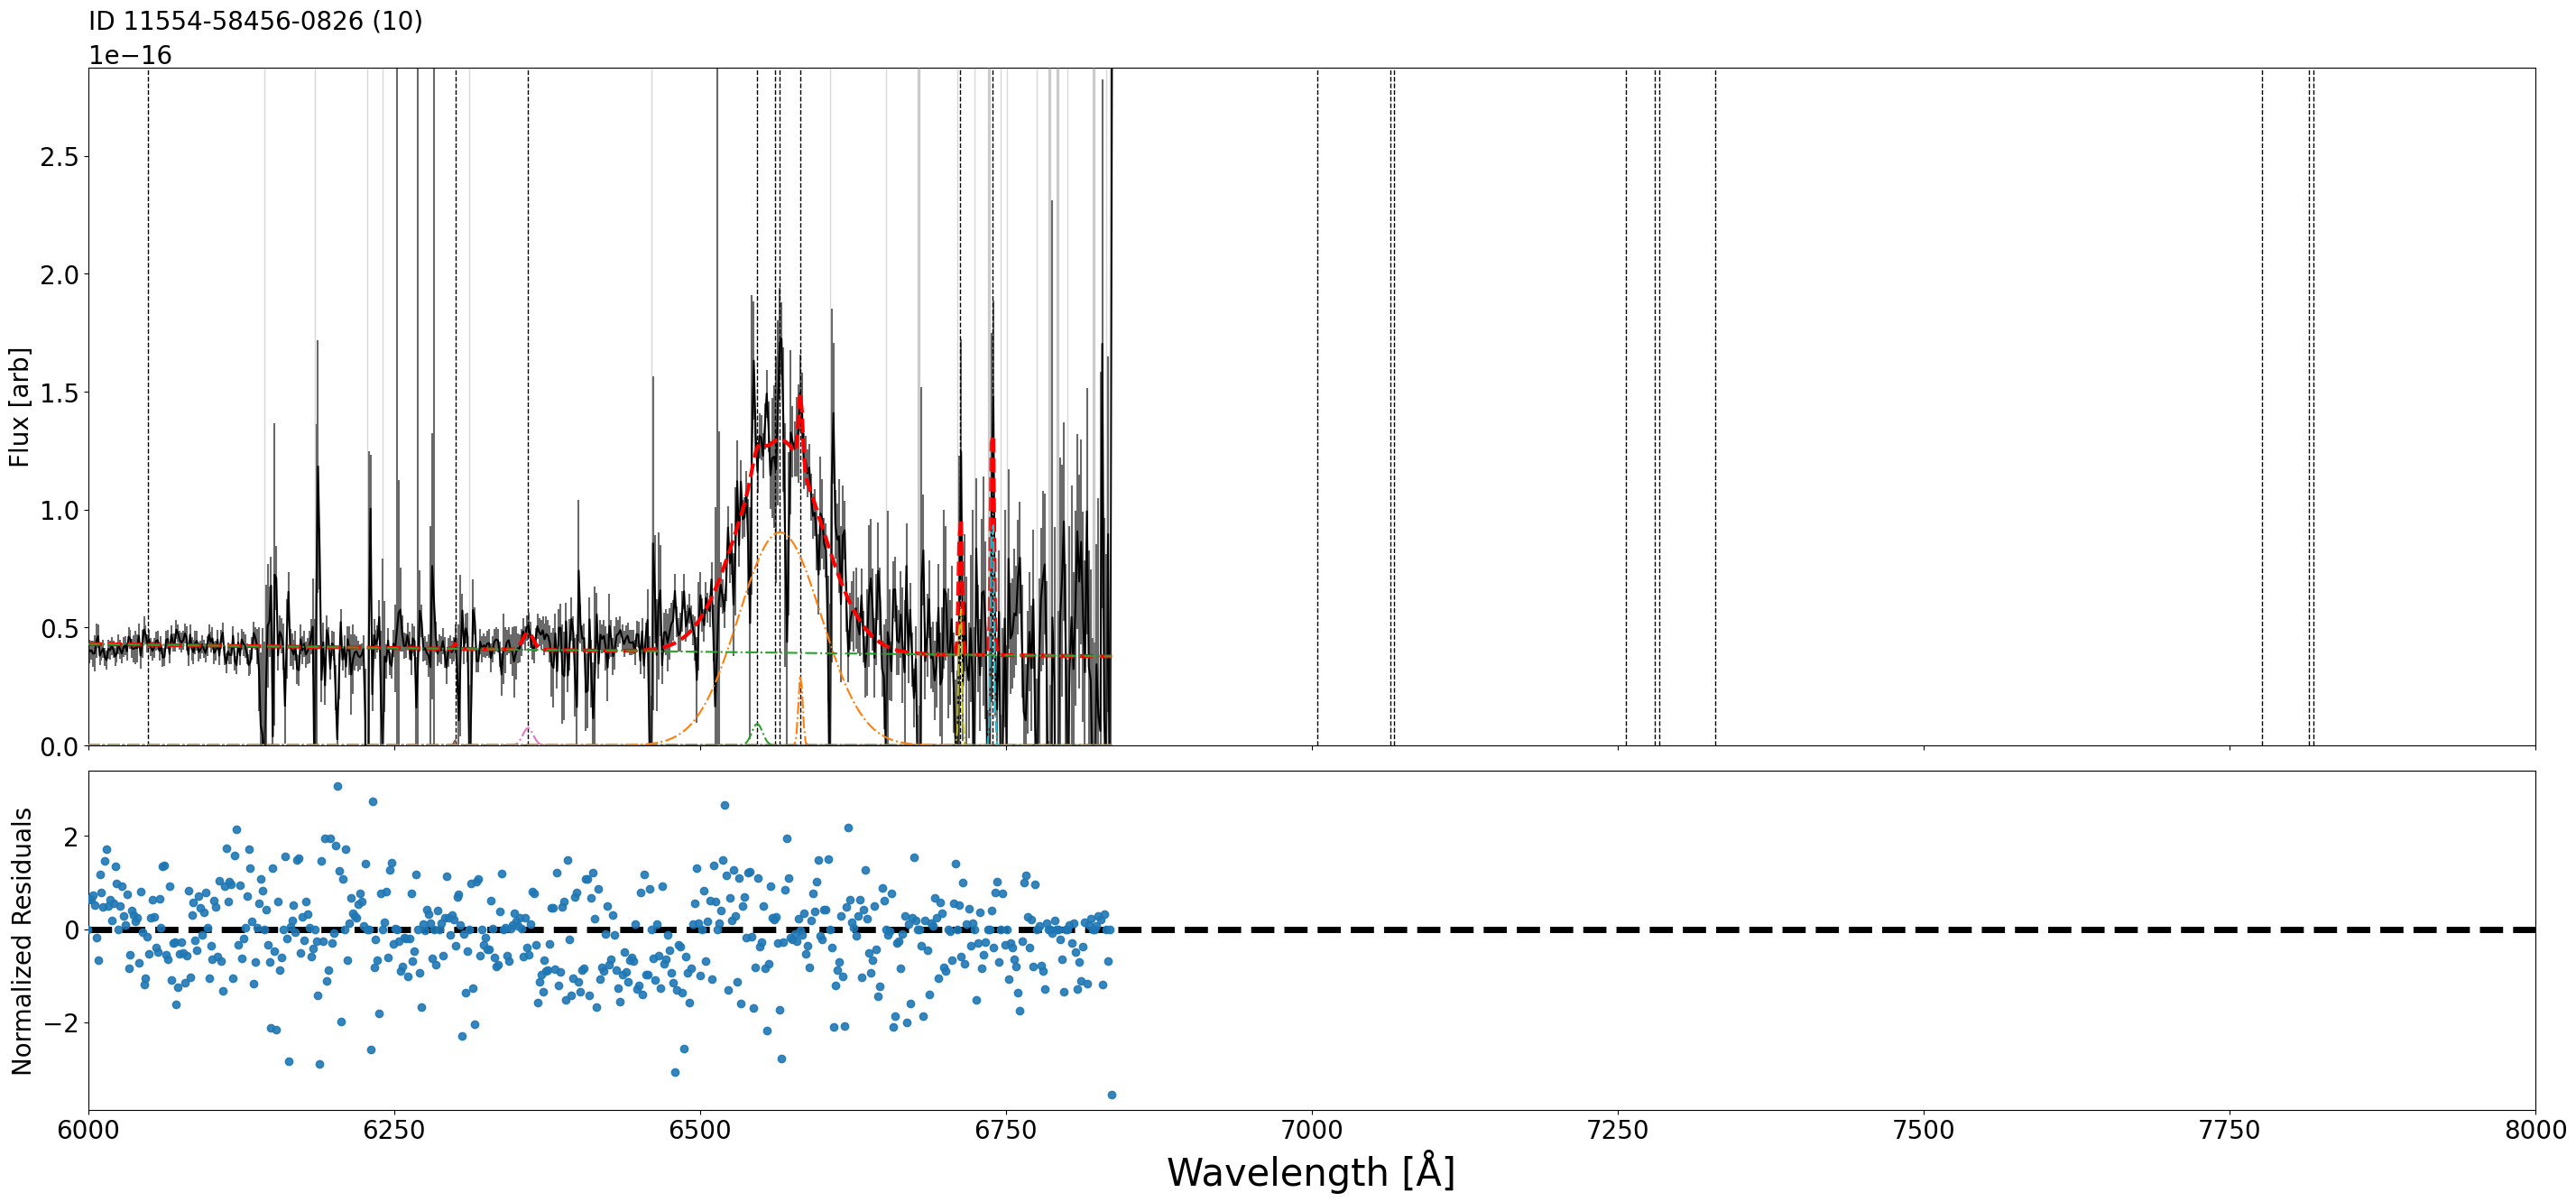

In [31]:
sp.plot(10)

In [ ]:
sheap

In [ ]:
model = combine_auto(sheapclass.profile_functions)

spectra = sheapclass.spectra.at[:,[1,2],:].multiply(10 ** (-1 * sheapclass.spectra_exp[:,jnp.newaxis,jnp.newaxis])) #apply escale to 0-20 max
#x,y,y_uncertainties = jnp.moveaxis(spectra,0,1)

In [17]:
y_uncertainties

Array([[1.36727987e-01, 1.25368409e+35, 6.37463372e-02, ...,
        4.89284224e-02, 3.95321940e-02, 4.10333095e-02],
       [3.73428750e-01, 1.60935051e+35, 1.18203982e-01, ...,
        1.11706040e-01, 1.22569858e+35, 1.42212773e-01],
       [1.98755600e+00, 1.55916915e+00, 1.36437078e+00, ...,
        6.30983384e-01, 6.07531607e-01, 6.22729110e-01],
       ...,
       [9.92178008e+00, 5.67143079e+37, 9.50605147e+00, ...,
        1.77416458e+01, 2.18658012e+01, 2.23323519e+01],
       [5.08460485e+00, 4.80851496e+00, 4.95735426e+00, ...,
        1.31482386e+01, 1.12968410e+01, 1.39500290e+01],
       [1.38288880e+01, 4.47319910e+37, 1.26725751e+01, ...,
        1.03959621e+01, 8.36828423e+00, 7.18745608e+00]], dtype=float64)

In [18]:
errrs_array_fulljacobian = batch_error_covariance_in_chunks(model,sheapclass.params, x, y, y_uncertainties)

In [ ]:
def residuals(func,params: jnp.ndarray, xs, y: jnp.ndarray, y_uncertainties: jnp.ndarray):
        predictions = func(xs, params)
            
        return jnp.abs(y - predictions) / y_uncertainties

def error_covariance_matrix_single(
    func: Callable,
    params_i: jnp.ndarray,
    xs_i: jnp.ndarray,
    y_i: jnp.ndarray,
    yerr_i: jnp.ndarray,
    free_params: int
) -> jnp.ndarray:
    residual = residuals(func, params_i, xs_i, y_i, yerr_i)
    
    # Jacobian w.r.t. params
    jac_fn = lambda p: residuals(func, p, xs_i, y_i, yerr_i)
    jacobian = jax.jacobian(jac_fn)(params_i)  # shape (n_data, n_params)
    
    JTJ = jacobian.T @ jacobian
    chi_square = jnp.sum(residual ** 2)
    dof = residual.shape[0] - free_params
    s_sq = chi_square / dof

    # Add small diagonal term to avoid singular matrix
    cov = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(params_i.shape[0])) * s_sq
    return jnp.sqrt(jnp.diag(cov))  # shape: (n_params,)

def batch_error_covariance_in_chunks(params, xs, y, yerr, batch_size=30):
    n = params.shape[0]
    results = []
    for i in range(0, n, batch_size):
        batch_fn = vmap(
            lambda p, x, y_, ye: error_covariance_matrix_single(model, p, x, y_, ye, 0),
            in_axes=(0, 0, 0, 0)
        )
        batch_res = batch_fn(
            params[i:i+batch_size],
            xs[i:i+batch_size],
            y[i:i+batch_size],
            yerr[i:i+batch_size]
        )
        results.append(batch_res)
    return jnp.concatenate(results, axis=0)

In [23]:
# import traceback
# import gc

# def try_batched_error_covariance(model, params, xs, y, yerr, free_params=0, max_batch=30):
#     n_total = params.shape[0]
#     batch_size = max_batch
#     results = []
#     i = 0
    
#     while i < n_total:
#         try:
#             current_batch_size = min(batch_size, n_total - i)
#             #print(current_batch_size)
#             print("from to:",i,i+current_batch_size)
#             batch_res = params[i:i+current_batch_size]
#             #i += current_batch_size
#             batch_fn = vmap(
#             lambda p, x, y_, ye: error_covariance_matrix_single(model, p, x, y_, ye, 0),
#             in_axes=(0, 0, 0, 0)
#         )
#             batch_res = batch_fn(
#                  params[i:i+current_batch_size],
#                  xs[i:i+current_batch_size],
#                  y[i:i+current_batch_size],
#                  yerr[i:i+current_batch_size]
#              )
#             results.append(batch_res)
#             i += current_batch_size
#             batch_size = min(current_batch_size + 5, max_batch)
#             del batch_res, batch_fn
#             jax.clear_backends()
#         except RuntimeError as e:
#             #del batch_res, batch_fn
#             gc.collect()
#             jax.clear_backends()
#             if "RESOURCE_EXHAUSTED" in str(e) or "out of memory" in str(e).lower():
#                 batch_size = max(1, batch_size // 2)
#                 print(f"DOOM at batch {i}-{i+current_batch_size}, reducing to batch_size={batch_size}")
#                 if batch_size == 1:
#                     print("Cannot reduce batch size further. Exiting.")
#                     raise e
#             else:
#                 print("nhandled error:")
#                 traceback.print_exc()
#                 raise e
#     return jnp.concatenate(results, axis=0)     

In [25]:
sheapclass.params[0]

Array([ 2.00894315e-16,  4.95928032e+03,  3.30821936e+00,  8.10082888e-17,
        4.95631249e+03,  1.03065752e+01,  6.69647717e-16,  5.00718759e+03,
        3.34017965e+00,  1.91399637e-16,  5.00322400e+03,  7.09788176e+00,
        3.91266536e-17,  4.68459956e+03,  3.12596923e+00,  3.01523411e-17,
        4.69250227e+03,  3.23249614e+01,  0.00000000e+00,  4.68622555e+03,
        1.06917175e+01,  0.00000000e+00,  4.47187876e+03,  2.98304969e+00,
        2.19810247e-18,  4.47735207e+03,  2.97090004e+01,  2.77747412e-17,
        4.47309803e+03,  8.72194019e+00,  1.24952858e-16,  4.86255319e+03,
        3.24313229e+00,  2.00929326e-16,  4.86776361e+03,  3.02371058e+01,
        1.47200808e-16,  4.86139516e+03,  1.16442246e+01, -1.34530884e+00,
        3.01781962e-15,  1.98675039e-16,  1.00000000e+01,  1.84632007e+01,
        0.00000000e+00, -1.00000000e+01,  1.15533171e+01,  2.95164983e-16,
        6.47891842e+00,  2.00689626e+01,  1.19620982e-16,  7.19677842e+00,
        1.72583568e+01,  

In [23]:
errrs_array_fulljacobian[0]

Array([2.98721270e-01, 3.65522747e+04, 3.65522747e+04, 1.61007430e-01,
       3.65522747e+04, 3.65522747e+04, 4.14897306e-01, 3.65522747e+04,
       3.65522747e+04, 2.21596088e-01, 3.65522747e+04, 3.65522747e+04,
       2.56946197e-01, 3.65522747e+04, 3.65522747e+04, 8.93090163e-02,
       3.65522747e+04, 3.65522747e+04, 1.91090335e-01, 3.65522747e+04,
       3.65522747e+04, 2.88223288e-01, 3.65522747e+04, 3.65522747e+04,
       1.56599340e-01, 3.65522747e+04, 3.65522747e+04, 2.39169167e-01,
       3.65522747e+04, 3.65522747e+04, 3.48656920e-01, 3.65522747e+04,
       3.65522747e+04, 1.15794379e-01, 3.65522747e+04, 3.65522747e+04,
       2.50167299e-01, 3.65522747e+04, 3.65522747e+04, 3.65522747e+04,
       5.96409693e-02, 3.01328149e-01, 3.65522747e+04, 3.65522747e+04,
       5.58226222e+00, 3.65522747e+04, 3.65522747e+04, 4.38687922e-01,
       3.65522747e+04, 3.65522747e+04, 6.17549576e-01, 3.65522747e+04,
       3.65522747e+04, 3.37529020e-01, 3.65522747e+04, 3.65522747e+04,
      

In [ ]:
def fisher_error_estimate(
    func: Callable,
    params_i: jnp.ndarray,
    xs_i: jnp.ndarray,
    y_i: jnp.ndarray,
    yerr_i: jnp.ndarray,
    free_params: int
) -> jnp.ndarray:
    def loss_fn(p):
        residual = residuals(func, p, xs_i, y_i, yerr_i)
        return jnp.sum(residual**2)

    loss, grad = value_and_grad(loss_fn)(params_i)  # grad: shape (n_params,)
    
    grad = jnp.nan_to_num(grad)
    JTJ = jnp.outer(grad, grad)  # Approximates Fisher matrix (1 sample)
    
    dof = y_i.shape[0] - free_params
    s_sq = loss / dof
    
    cov = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(grad.shape[0])) * s_sq
    return jnp.sqrt(jnp.diag(cov))

def batch_fisher_errors(func, params, xs, y, yerr, free_params=0):
    return vmap(
        lambda p, x, y_, ye: fisher_error_estimate(func, p, x, y_, ye, free_params),
        in_axes=(0, 0, 0, 0)
    )(params, xs, y, yerr)

In [12]:
resid_array = sheapclass.params #batch_error_covariance_in_chunks(params, xs, y, yerr, batch_size=30)

In [13]:
resid_array = batch_fisher_errors(model,sheapclass.params, x, y, y_uncertainties)


In [29]:
sheapclass.params_dict

{'amplitude_OIIIb_1_narrow': 0,
 'center_OIIIb_1_narrow': 1,
 'width_OIIIb_1_narrow': 2,
 'amplitude_OIIIb_10_outflow': 3,
 'center_OIIIb_10_outflow': 4,
 'width_OIIIb_10_outflow': 5,
 'amplitude_OIIIc_1_narrow': 6,
 'center_OIIIc_1_narrow': 7,
 'width_OIIIc_1_narrow': 8,
 'amplitude_OIIIc_10_outflow': 9,
 'center_OIIIc_10_outflow': 10,
 'width_OIIIc_10_outflow': 11,
 'amplitude_HeIId_1_narrow': 12,
 'center_HeIId_1_narrow': 13,
 'width_HeIId_1_narrow': 14,
 'amplitude_HeIId_1_broad': 15,
 'center_HeIId_1_broad': 16,
 'width_HeIId_1_broad': 17,
 'amplitude_HeIId_2_broad': 18,
 'center_HeIId_2_broad': 19,
 'width_HeIId_2_broad': 20,
 'amplitude_HeId_1_narrow': 21,
 'center_HeId_1_narrow': 22,
 'width_HeId_1_narrow': 23,
 'amplitude_HeId_1_broad': 24,
 'center_HeId_1_broad': 25,
 'width_HeId_1_broad': 26,
 'amplitude_HeId_2_broad': 27,
 'center_HeId_2_broad': 28,
 'width_HeId_2_broad': 29,
 'amplitude_Hbeta_1_narrow': 30,
 'center_Hbeta_1_narrow': 31,
 'width_Hbeta_1_narrow': 32,
 'ampli

In [28]:
errrs_array_fulljacobian[0]

Array([8.22047668e-17, 1.02955880e+00, 1.41816061e+00, 7.56462432e-17,
       6.15491411e+00, 6.21661001e+00, 1.60967028e-16, 5.51895055e-01,
       6.83782968e-01, 1.48964648e-16, 3.84943175e+00, 2.02751441e+00,
       5.28642301e-17, 3.95534724e+00, 5.14003667e+00, 7.29343685e-17,
       9.84806191e+01, 4.25382759e+01, 7.45734684e-17, 7.14303863e+03,
       7.14303863e+03, 8.37286836e-17, 7.14303863e+03, 7.14303863e+03,
       2.23944784e-16, 7.29061214e+02, 1.43031772e+03, 3.04695889e-16,
       3.34495021e+01, 3.54498859e+01, 9.67056370e-17, 1.86669705e+00,
       2.71085596e+00, 1.00344125e-16, 9.12653657e+00, 6.02459059e+00,
       9.94422267e-17, 4.13581345e+00, 8.38020333e+00, 1.37961272e-02,
       7.10102307e-17, 1.82444829e-16, 2.00825773e+01, 1.75267247e+01,
       4.50521884e-15, 7.14303863e+03, 7.14303863e+03, 1.24955953e-16,
       1.09055903e+01, 1.12995972e+01, 1.53090996e-16, 2.48592164e+01,
       2.73597220e+01, 1.94364912e-16, 1.07200193e+01, 6.93240775e+00,
      

In [62]:
import gc
gc.collect()

0

In [ ]:
# import jax
# import jax.numpy as jnp
import traceback

def try_batched_error_covariance(model, params, xs, y, yerr, free_params=0, max_batch=64):
    n_total = params.shape[0]
    batch_size = max_batch
    results = []

    i = 0
    while i < n_total:
        current_batch_size = min(batch_size, n_total - i)
        try:
            batch_fn = jax.vmap(
                lambda p, x, y_, ye: error_covariance_matrix_single(
                    model, p, x, y_, ye, free_params
                ),
                in_axes=(0, 0, 0, 0)
            )
            # Try this batch
            batch_res = batch_fn(
                params[i:i+current_batch_size],
                xs[i:i+current_batch_size],
                y[i:i+current_batch_size],
                yerr[i:i+current_batch_size]
            )
            results.append(batch_res)
            i += current_batch_size
            # If it worked, try increasing batch size slightly next time
            batch_size = min(batch_size + 5, max_batch)

        except RuntimeError as e:
            if "RESOURCE_EXHAUSTED" in str(e) or "out of memory" in str(e).lower():
                batch_size = max(1, batch_size // 2)
                print(f"DOOM at batch {i}-{i+current_batch_size}, reducing to batch_size={batch_size}")
                if batch_size == 1:
                    print("Cannot reduce batch size further. Exiting.")
                    raise e
            else:
                print("nhandled error:")
                traceback.print_exc()
                raise e

    return jnp.concatenate(results, axis=0)



In [20]:
#7.minutes cpu 
#30, 1.46 #max ->
resid_array = try_batched_error_covariance(model,sheapclass.params, x, y, y_uncertainties)

0


2025-05-15 04:52:02.077551: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB (rounded to 3406239488)requested by op 
2025-05-15 04:52:02.078726: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *_________________***********************************************************************__*********
E0515 04:52:02.078768 2283107 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3406239360 bytes.


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3406239360 bytes.

In [9]:
batched_error_covariance = vmap(
    lambda params_i, xs_i, y_i, yerr_i: error_covariance_matrix_single(
        model, params_i, xs_i, y_i, yerr_i, 0
    ),
    in_axes=(0, 0, 0, 0)
)
resid_array = batched_error_covariance(sheapclass.params, x, y, y_uncertainties)

: 

2025-05-15 03:59:34.756924: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below -17.20GiB (-18464240234 bytes) by rematerialization; only reduced to 35.69GiB (38320192800 bytes), down from 35.69GiB (38320192800 bytes) originally
2025-05-15 03:59:44.808255: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.69GiB (rounded to 38320193024)requested by op 
2025-05-15 03:59:44.808890: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ******************__________________________________________________________________________________
E0515 03:59:44.808944 2275759 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38320192800 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 38320192800 bytes.

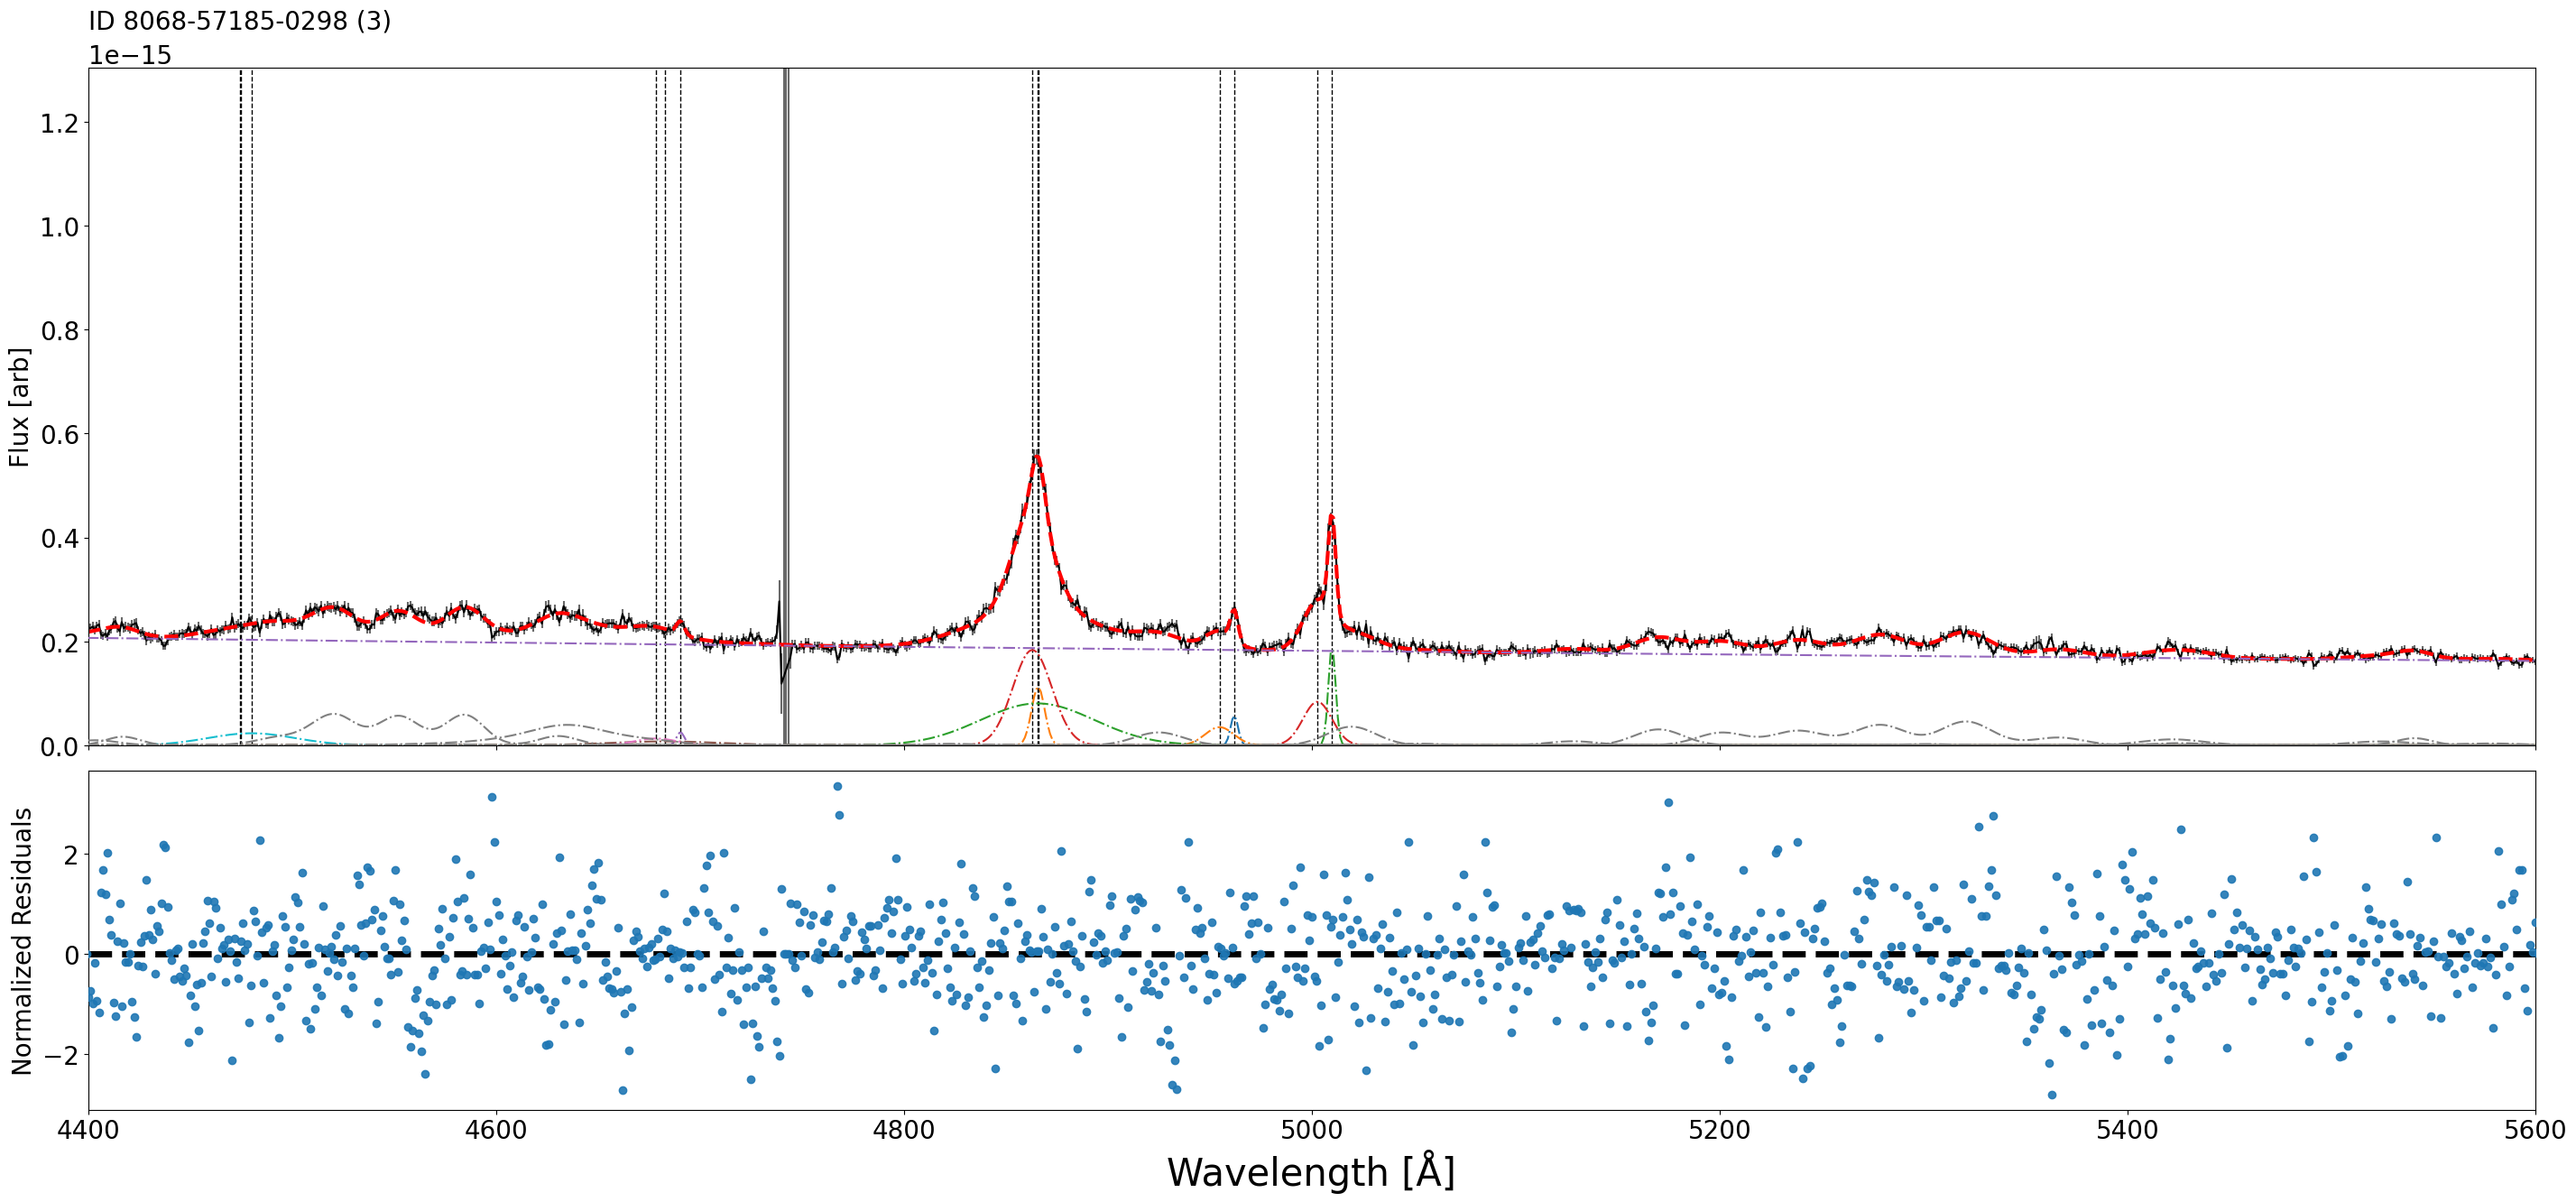

In [6]:
region_plot = SheapPlot(sheapclass)
region_plot.plot(3,add_name=False)#207

In [126]:
sheapclass.build_region(4400, 5600,fe_mode="sum",n_broad=2,add_outflow=True,by_region=True,force_linear=False,add_balmercontiniumm=True)

In [124]:
sheapclass.builded_region.complex_region

[SpectralLine(center=4412.3, line_name='ArXIVa', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4567.4697, line_name='FeXIa', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4588.5537, line_name='FeIXa', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4658.05, line_name='FeIIIa', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4698.24, line_name='FeVIIb', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4711.26, line_name='ArIVa', kind='fe', component=20, amplitude=0.1, how='sum', region='feii_coronal', profile=None, which=None),
 SpectralLine(center=4740.12, line_name='ArIVb', kind='fe', component=20, amplitude=0.1, how='

In [104]:
sheapclass.fit_region([100,100])

Fitting 225 spectra
STEP1
learning_rate: 0.1 num_steps: 3000 non_optimize_in_axis: 3
STEP2
learning_rate: 0.01 num_steps: 3000 non_optimize_in_axis: 4


In [ ]:
sheapclass.complex_region

{'complex_region': [SpectralLine(center=4958.896072, line_name='OIIIb', kind='narrow', component=1, amplitude=1.0, how=None, region='narrow_basic', profile='gaussian', which=None),
  SpectralLine(center=4958.896072, line_name='OIIIb', kind='outflow', component=10, amplitude=0.5, how=None, region='narrow_basic', profile='gaussian', which=None),
  SpectralLine(center=5006.803341, line_name='OIIIc', kind='narrow', component=1, amplitude=1.0, how=None, region='narrow_basic', profile='gaussian', which=None),
  SpectralLine(center=5006.803341, line_name='OIIIc', kind='outflow', component=10, amplitude=0.5, how=None, region='narrow_basic', profile='gaussian', which=None),
  SpectralLine(center=4685.71, line_name='HeIId', kind='narrow', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
  SpectralLine(center=4685.71, line_name='HeIId', kind='broad', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
  SpectralLine(center

In [105]:
sheapclass.complex_region

[SpectralLine(center=4958.896072, line_name='OIIIb', kind='narrow', component=1, amplitude=1.0, how=None, region='narrow_basic', profile='gaussian', which=None),
 SpectralLine(center=4958.896072, line_name='OIIIb', kind='outflow', component=10, amplitude=0.5, how=None, region='narrow_basic', profile='gaussian', which=None),
 SpectralLine(center=5006.803341, line_name='OIIIc', kind='narrow', component=1, amplitude=1.0, how=None, region='narrow_basic', profile='gaussian', which=None),
 SpectralLine(center=5006.803341, line_name='OIIIc', kind='outflow', component=10, amplitude=0.5, how=None, region='narrow_basic', profile='gaussian', which=None),
 SpectralLine(center=4685.71, line_name='HeIId', kind='narrow', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
 SpectralLine(center=4685.71, line_name='HeIId', kind='broad', component=1, amplitude=1.0, how=None, region='helium', profile='gaussian', which=None),
 SpectralLine(center=4685.71, line_name='HeII

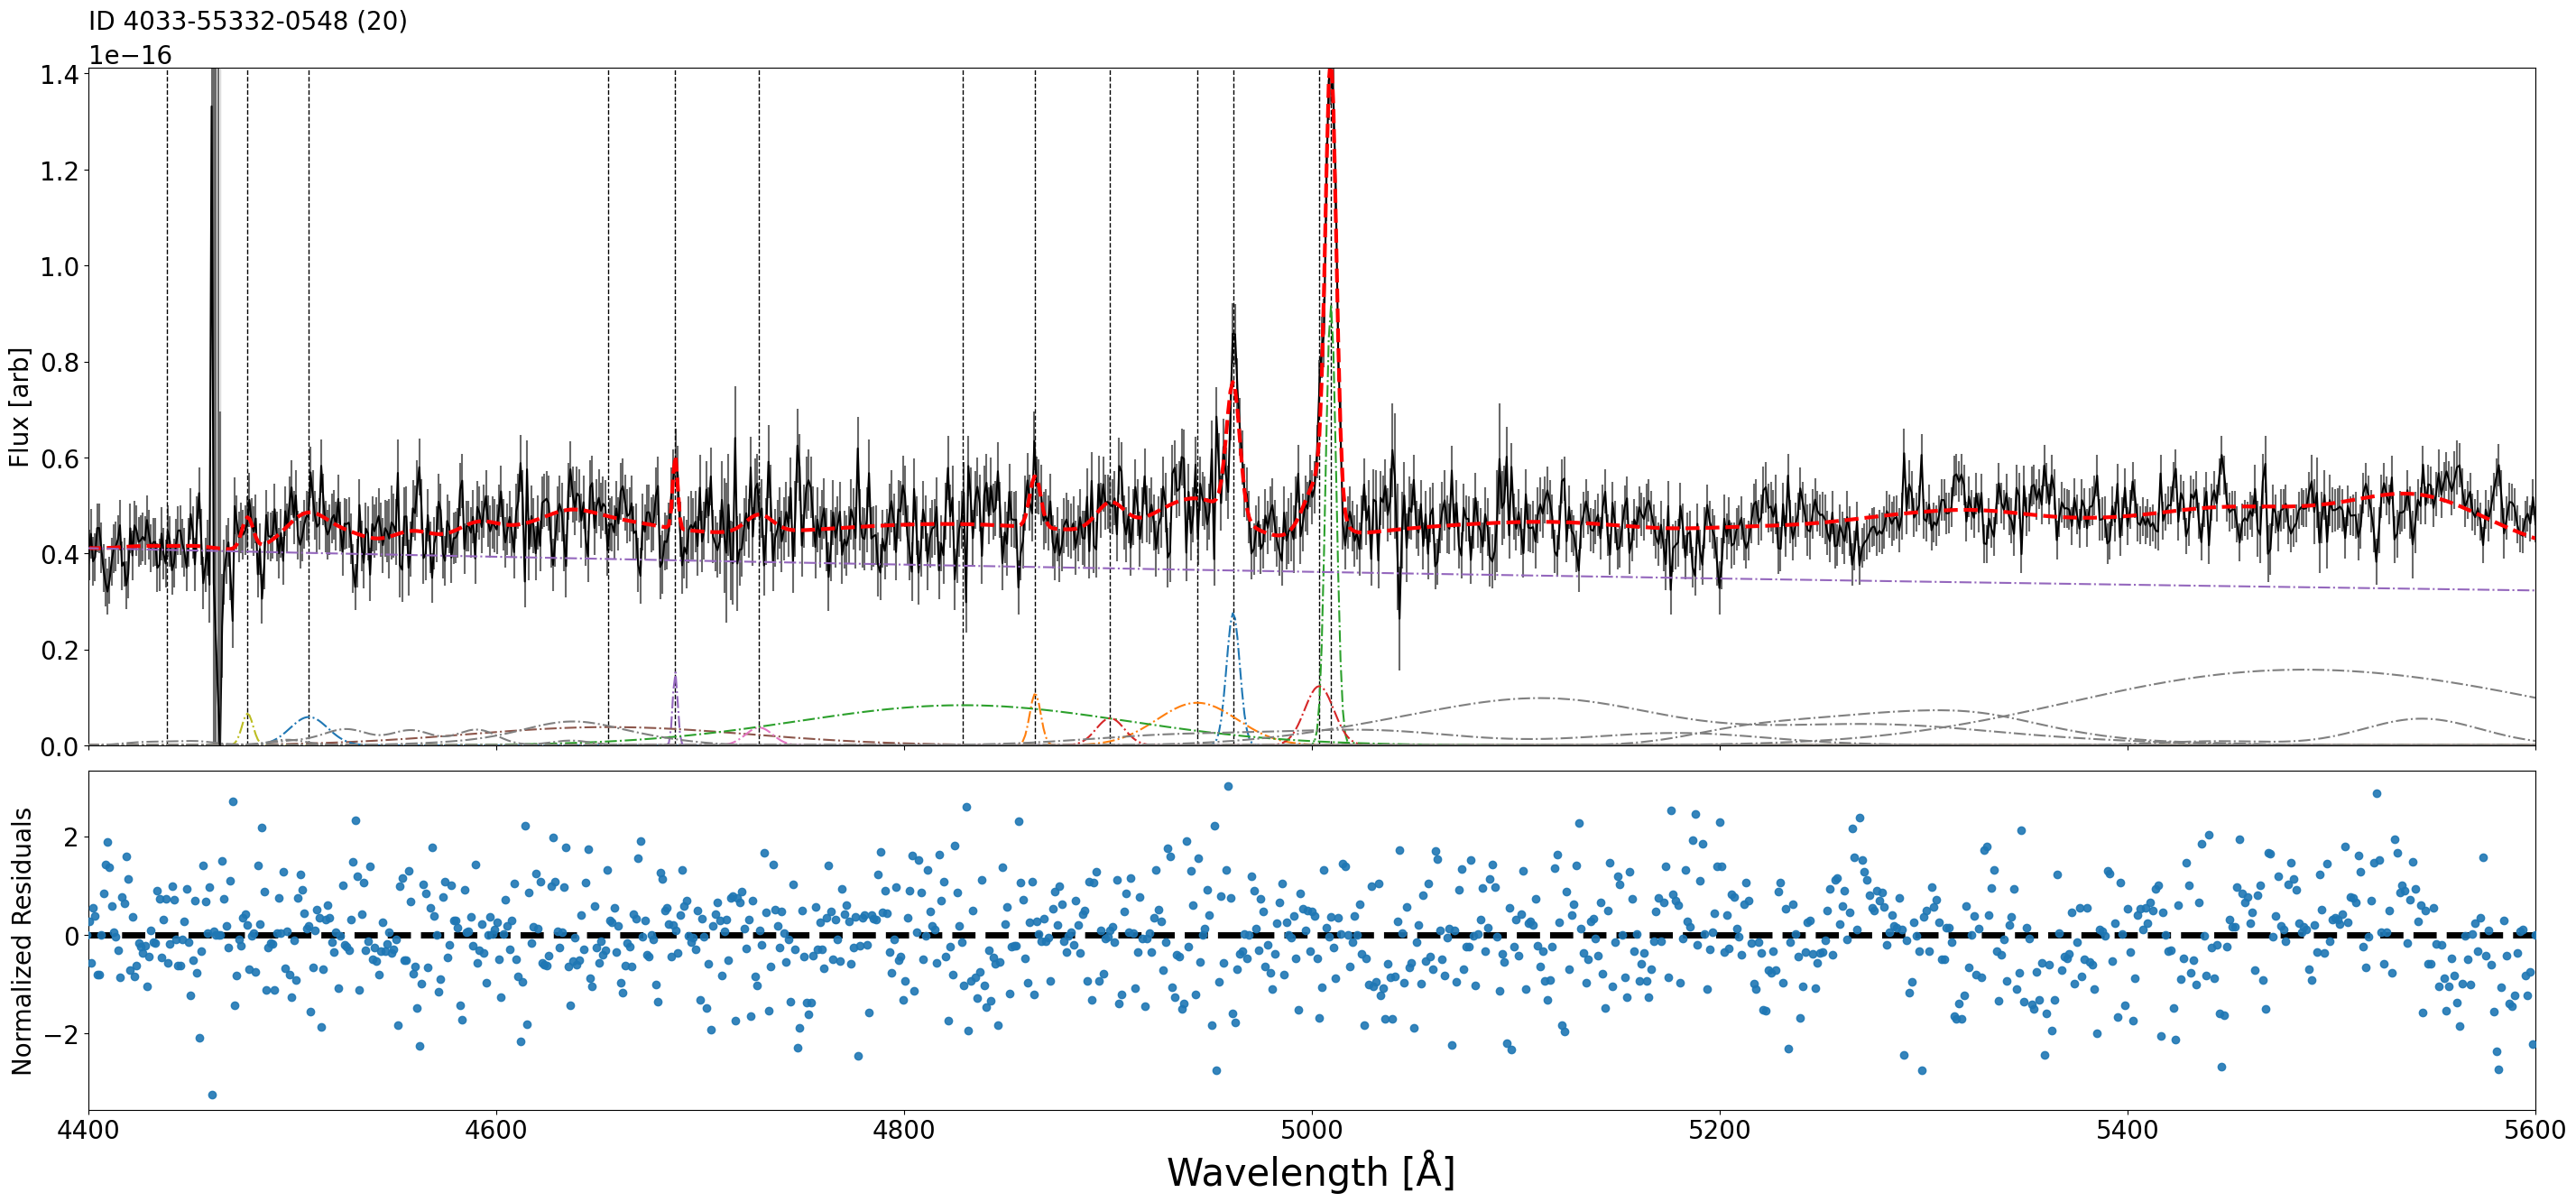

In [141]:
region_plot = SheapPlot(sheapclass)
region_plot.plot(20,add_name=False)#207

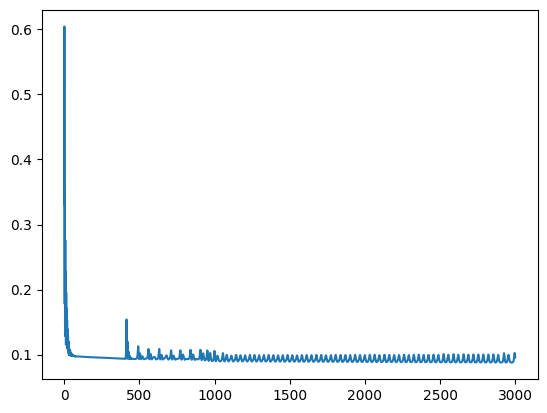

In [31]:
plt.plot(jnp.array(sheapclass.loss).T[3])

In [ ]:

from jax import vmap 

In [ ]:
# Must be first, before jax.numpy or anything else
from jax import config
config.update("jax_platform_name", "cpu")

# Now safe to import
import jax
import jax.numpy as jnp
from jax import jit, vmap




2025-05-15 03:52:03.495746: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB (rounded to 5109359104)requested by op 
2025-05-15 03:52:03.497612: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *********************************************************************************___________________
E0515 03:52:03.497653 2268644 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5109359040 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5109359040 bytes.

In [ ]:
#from jax import config
#config.update("jax_platform_name", "cpu")

In [38]:
resid_array[1]

Array([8.41879290e-17, 1.81649719e+00, 2.25098958e+00, 5.64876376e-17,
       3.76486864e+00, 5.89278585e+00, 1.10581182e-16, 7.96007756e-01,
       1.05368866e+00, 8.99321131e-17, 4.06759941e+00,            nan,
       1.58422241e-16, 1.12152664e+01, 1.94246691e+01, 3.52259519e-16,
       1.51901468e+03,            nan, 1.30789089e-16, 3.53720416e+01,
       1.00346305e+02, 1.08226376e-16, 6.67249174e+03, 6.67249174e+03,
       1.10874724e-16, 6.67249174e+03, 6.67249174e+03, 1.36577256e-16,
       8.08416098e+01, 6.31537005e+01, 1.60169644e-16, 4.77492435e+00,
       6.70599978e+00, 6.00028124e-17, 6.24439523e+00,            nan,
       1.50729547e-16, 1.19191060e+01, 1.63234053e+01, 1.60597245e-02,
       6.85389101e-17, 2.00495431e-16, 2.11409455e+01, 1.09839533e+01,
       3.71497172e-15, 6.67249174e+03, 6.67249174e+03, 2.31843618e-16,
       3.26920532e+01, 2.33012207e+01, 2.50494663e-16, 3.77861773e+01,
       4.02704530e+01, 3.52374716e-16, 5.08086300e+01, 3.91738943e+01,
      

In [27]:
resid_array

Array([[8.22047668e-17, 1.02955880e+00, 1.41816061e+00, 7.56462432e-17,
        6.15491411e+00, 6.21661001e+00, 1.60967028e-16, 5.51895055e-01,
        6.83782968e-01, 1.48964648e-16, 3.84943175e+00, 2.02751441e+00,
        5.28642301e-17, 3.95534724e+00, 5.14003667e+00, 7.29343685e-17,
        9.84806191e+01, 4.25382759e+01, 7.45734684e-17, 7.14303863e+03,
        7.14303863e+03, 8.37286836e-17, 7.14303863e+03, 7.14303863e+03,
        2.23944784e-16, 7.29061214e+02, 1.43031772e+03, 3.04695889e-16,
        3.34495021e+01, 3.54498859e+01, 9.67056370e-17, 1.86669705e+00,
        2.71085596e+00, 1.00344125e-16, 9.12653657e+00, 6.02459059e+00,
        9.94422267e-17, 4.13581345e+00, 8.38020333e+00, 1.37961272e-02,
        7.10102307e-17, 1.82444829e-16, 2.00825773e+01, 1.75267247e+01,
        4.50521884e-15, 7.14303863e+03, 7.14303863e+03, 1.24955953e-16,
        1.09055903e+01, 1.12995972e+01, 1.53090996e-16, 2.48592164e+01,
        2.73597220e+01, 1.94364912e-16, 1.07200193e+01, 6.932407

In [ ]:
sheapclass.params[0:2]

(2, 71)

In [ ]:
@jit
def error_covariance_matrix_method(
    optimized_params_flat: jnp.ndarray,
    xs: List[jnp.ndarray],
    y: jnp.ndarray,
    y_uncertainties: jnp.ndarray,
    free_params: int
) -> jnp.ndarray:
    """
    Calculate the error covariance matrix based on residuals for multiple input variables.

    Parameters:
    - optimized_params_flat: Optimized parameters as a flat array.
    - xs: List of input data arrays (e.g., [x1, x2, ...]).
    - y: Target data.
    - y_uncertainties: Uncertainties in target data.
    - free_params: Number of free parameters in the model.

    Returns:
    - Standard errors for each parameter.
    """
    residual = residuals(optimized_params_flat, xs, y, y_uncertainties)
    jacobian = jax.jacobian(residuals)(optimized_params_flat, xs, y, y_uncertainties)
    JTJ = jacobian.T @ jacobian
    chi_square = jnp.sum(residual ** 2)
    degrees_of_freedom = len(residual) - free_params
    s_sq = chi_square / degrees_of_freedom
    covariance_matrix = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(len(optimized_params_flat))) * s_sq
    return jnp.sqrt(jnp.diag(covariance_matrix))

TypeError: Expected a callable value, got [2.41582801e-16 2.40315369e-16 2.39045512e-16 ... 4.67460099e-17
 7.63546085e-17 7.80339345e-17]

In [176]:
from jax import vmap 
batched_residuals = vmap(
    lambda xs_i, params_i, y_i, yerr_i: residuals(model, params_i, xs_i, y_i, yerr_i),
    in_axes=(0, 0, 0, 0)
)

In [182]:
from jax import vmap

def residuals(func, params: jnp.ndarray, xs, y: jnp.ndarray, y_uncertainties: jnp.ndarray):
    predictions = func(xs, params)  # returns shape (4614,)
    return jnp.abs(y - predictions) / y_uncertainties  # shape (4614,)

# vmap over the 225 spectra
batched_residuals = vmap(
    lambda params_i, xs_i, y_i, yerr_i: residuals(model, params_i, xs_i, y_i, yerr_i),
    in_axes=(0, 0, 0, 0)
)

# usage:
resid_array = batched_residuals(sheapclass.params, x, y, y_uncertainties)


In [ ]:
def error_covariance_matrix_single(
    func: Callable,
    params_i: jnp.ndarray,
    xs_i: jnp.ndarray,
    y_i: jnp.ndarray,
    yerr_i: jnp.ndarray,
    free_params: int
) -> jnp.ndarray:
    residual = residuals(func, params_i, xs_i, y_i, yerr_i)
    
    # Jacobian w.r.t. params
    jac_fn = lambda p: residuals(func, p, xs_i, y_i, yerr_i)
    jacobian = jax.jacobian(jac_fn)(params_i)  # shape (n_data, n_params)
    
    JTJ = jacobian.T @ jacobian
    chi_square = jnp.sum(residual ** 2)
    dof = residual.shape[0] - free_params
    s_sq = chi_square / dof

    # Add small diagonal term to avoid singular matrix
    cov = jnp.linalg.inv(JTJ + 1e-6 * jnp.eye(params_i.shape[0])) * s_sq
    return jnp.sqrt(jnp.diag(cov))  # shape: (n_params,)


NameError: name 'Callable' is not defined

In [159]:
jacobian = jax.vmap(jax.grad(lambda p, xi, yi: jnp.abs(yi - model(xi,p )) ))(sheapclass.params, x, y)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (4614,).